## Experimentation file for Mood Classification:
By
Ashlesha Shinde,
Chhavi Sharma,
Prahasan Gadugu,
Supriya Ayalur Balasubramanian.

####Code Citations:

https://developers.google.com/machine-learning/guides/text-classification/step-4 - 1 Oct 2018, Google Team

https://github.com/rasbt/musicmood - Sebastian Raschka - 1 November 2016

https://github.com/AnuragDharNEU/AdvancedDataScience/tree/master/Song_Mood_Classifier_Flask_Heroku - Anurag Dhar - 8 April 2019

https://github.com/google/eng-edu/tree/master/ml/guides/text_classification - Pavith Rasav 17 July 2018

## Data Preparation

In [0]:
#Importing all the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
import warnings
warnings.simplefilter("ignore")

mood_model_accuracies=[]
mood_model_name=[]
mood_tfidf_model_accu=[]
mood_tfidf_model_name=[]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
#Reading the csv files
train_lyrics = pd.read_csv("train_lyrics_1000.csv")
valid_lyrics = pd.read_csv("valid_lyrics_200.csv")

Text(0, 0.5, 'Number of samples')

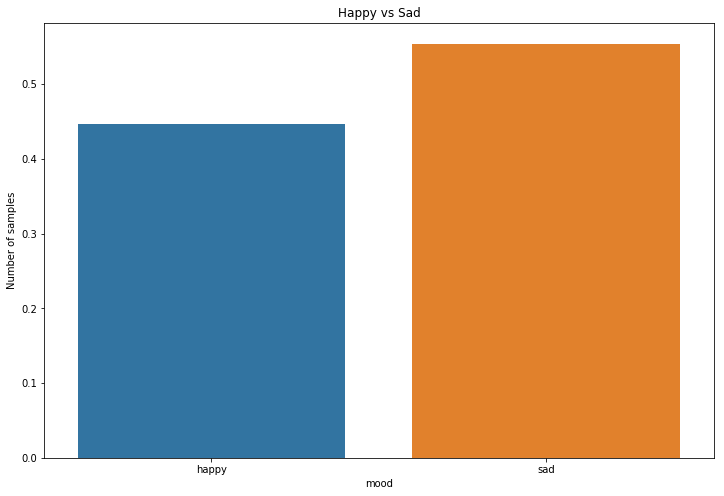

In [0]:
#Checking for imbalance of Labels
plot_imbal_labels = train_lyrics.groupby(["mood"]).size()
plot_imbal_labels = plot_imbal_labels / plot_imbal_labels.sum()
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(plot_imbal_labels.keys(), plot_imbal_labels.values).set_title("Happy vs Sad")
ax.set_ylabel('Number of samples')

In [0]:
#preprocess_lyric fucntion to clean the lyric file.
def preprocess_lyric(given_lyric):
    lyric = given_lyric
    lyric = re.sub('[^a-zA-Z]', ' ',lyric)
    lyric = lyric.lower()
    lyric = lyric.split()
    lemmatizer = WordNetLemmatizer()
    lyric = [lemmatizer.lemmatize(w) for w in lyric if not w in set(stopwords.words('english'))]
    return (' '.join(lyric))

In [0]:
#Cleaning the train and valid data and adding it into respective data frames
print("Cleaning the train set............")
train_lyrics['Cleaned_Lyric'] = train_lyrics["lyrics"].apply(lambda x :preprocess_lyric(x))
train_lyrics.to_csv("mood_cleaned_lyrics.tsv", sep='\t', index = False)
print("Cleaned train lyrics loaded to tsv file............")
valid_lyrics['Cleaned_Lyric'] = valid_lyrics["lyrics"].apply(lambda x :preprocess_lyric(x))

Cleaning the train set............
Cleaned train lyrics loaded to tsv file............


(-0.5, 799.5, 499.5, -0.5)

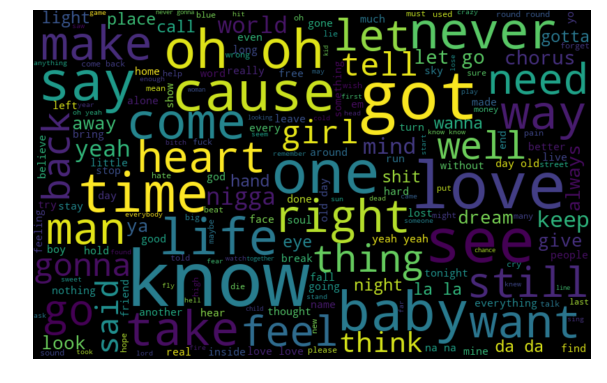

In [0]:
#Word Cloud for all corpus:

all_words = ' '.join([text for text in train_lyrics['Cleaned_Lyric']])
Happy_lyrics = ' '.join(train_lyrics.loc[train_lyrics.mood == 'happy', 'Cleaned_Lyric'].values)
Sad_lyrics = ' '.join(train_lyrics.loc[train_lyrics.mood == 'sad', 'Cleaned_Lyric'].values)
import wordcloud
from wordcloud import WordCloud
wordcloud_all = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_all, interpolation="bilinear")
plt.axis('off')

(-0.5, 799.5, 499.5, -0.5)

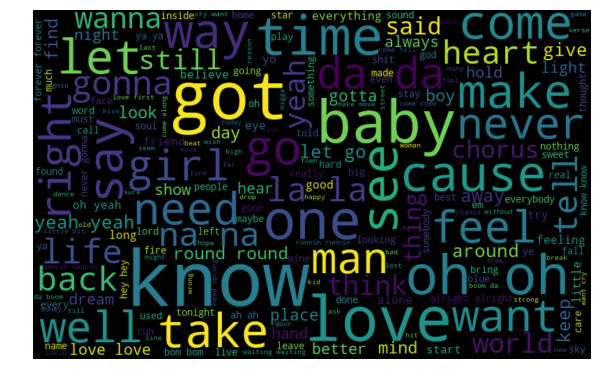

In [0]:
#Word cloud for only happy corpus:

wordcloud_happy = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(Happy_lyrics)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_happy, interpolation="bilinear")
plt.axis('off')

(-0.5, 799.5, 499.5, -0.5)

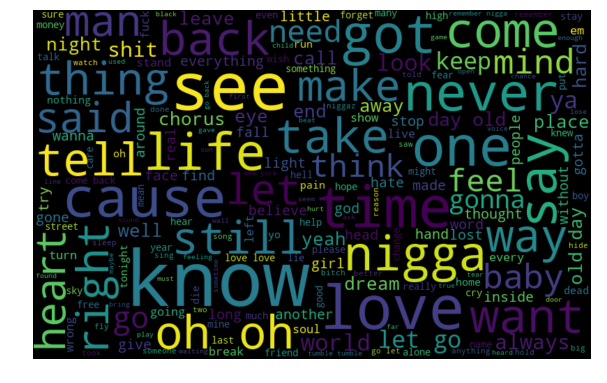

In [0]:
#Word cloud for only sad corpus:

wordcloud_sad = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(Sad_lyrics)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_sad, interpolation="bilinear")
plt.axis('off')

## Modelling using Google Text Classification Algorithm:

In [0]:
'''
We are checking no. of words per samples to no. of sample ratio as 
criteria to create our model using n-gram approach or sequence approach. 
If s_w_ratio>1500, sequence approach otherwise n-gram.

'''

import numpy as np
def get_num_words_per_sample(sample_texts):
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

number_of_words_per_sample = get_num_words_per_sample(train_lyrics['Cleaned_Lyric'])
no_of_samples = train_lyrics.shape[0]

s_w_ratio  = no_of_samples/number_of_words_per_sample
print(s_w_ratio)

10.204081632653061


## Baseline Modeling:
### Implementation of Bag-Of-Words:

In [0]:
#Importing all the necessary libraries for modeling:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
cv = CountVectorizer(max_features = 10)

In [0]:
X_train_bow = cv.fit_transform(train_lyrics['Cleaned_Lyric']).toarray()
X_test_bow = cv.fit_transform(valid_lyrics['Cleaned_Lyric']).toarray()

y_train = train_lyrics["mood"]
y_test = valid_lyrics["mood"]

In [0]:
#Logistic Regression Model:
log_reg_classifier = LogisticRegression(
						 penalty='l2', 
						 C=0.5		
						 )

log_reg_classifier.fit(X_train_bow,y_train)
y_pred_valid_log = log_reg_classifier.predict(X_test_bow)
log_score = accuracy_score(y_pred_valid_log,y_test)
print("Logistic regression model with B-O-W", log_score*100, "%")
mood_model_accuracies.append(log_score*100)
mood_model_name.append("Logistic Regression")

Logistic regression model with B-O-W 49.5 %


In [0]:
#Naive Bayes 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
classifier_mulnb = MultinomialNB()
classifier_mulnb.fit(X_train_bow, y_train)
y_test_pred_nulnb = classifier_mulnb.predict(X_test_bow)
mulnb_score = accuracy_score(y_test,y_test_pred_nulnb)
print("Multinomial Naive Bayes with B-O-W ", mulnb_score*100,"%")
mood_model_accuracies.append(mulnb_score*100)
mood_model_name.append("Multinomial Naive Bayes")

Multinomial Naive Bayes with B-O-W  57.99999999999999 %


In [0]:
#SVM Model
from sklearn.svm import LinearSVC
svm_clf =LinearSVC(
        C=1.0,
        class_weight='balanced',
        dual=False,
        fit_intercept=True,
        intercept_scaling=1,
        loss='squared_hinge',
        max_iter=1000,
        multi_class='ovr',
        penalty='l2',
        random_state=0,
        tol=1e-05, 
        verbose=0
    )

print("Training SVM ...............")
svm_clf.fit(X_train_bow, y_train)
y_test_pred_svm = svm_clf.predict(X_test_bow)
svm_score = accuracy_score(y_test,y_test_pred_svm)
print("SVM score", svm_score*100,"%")
mood_model_accuracies.append(svm_score*100)
mood_model_name.append("Linear SVC")

Training SVM ...............
SVM score 54.0 %


In [0]:
#Random Forests
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=1000, max_depth=10,random_state=0)
print("Training RF ...............")
rf_clf.fit(X_train_bow, y_train)
y_test_pred_rf = rf_clf.predict(X_test_bow)
rf_score = accuracy_score(y_test,y_test_pred_rf)
print("RF score", rf_score*100,"%")
mood_model_accuracies.append(rf_score*100)
mood_model_name.append("Random Forest")

Training RF ...............
RF score 54.0 %


##Implementing the Baseline Models with TF-IDF Vectorization

In [0]:
# Linear SVC with TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

svc = LinearSVC(
    C=1.0,
    class_weight='balanced',
    dual=True,
    fit_intercept=True,
    intercept_scaling=1,
    loss='squared_hinge',
    max_iter=1000,
    multi_class='ovr',
    penalty='l2',
    random_state=0,
    tol=1e-05, 
    verbose=2
)

tfidf = TfidfVectorizer(
    input='content',
    encoding='utf-8',
    decode_error='replace',
    strip_accents='unicode',
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    stop_words='english',
    ngram_range=(1, 3),
    analyzer='word',
    max_df=1.0,
    min_df=2,
    max_features=None,
    vocabulary=None,
    binary=False
)

pipeline = Pipeline([
    ('tfidf', tfidf),
    ('svc', svc),
])


pipeline.fit(train_lyrics['Cleaned_Lyric'],y_train)
y_test_pred_lsvc = pipeline.predict(valid_lyrics['Cleaned_Lyric'])

pip_score = accuracy_score(y_test,y_test_pred_lsvc)
print("Linear SVC score", pip_score*100,"%")
mood_tfidf_model_accu.append(pip_score*100)
mood_tfidf_model_name.append("Linear SVC with TF-IDF")

[LibLinear]Linear SVC score 73.0 %


In [0]:
#Logistic Regression with TF-IDF
pipeline_2 = Pipeline([
    ('tfidf', tfidf),
    ('logisticreg', log_reg_classifier),
])

pipeline_2.fit(train_lyrics['Cleaned_Lyric'],y_train)
y_test_pred_logreg = pipeline_2.predict(valid_lyrics['Cleaned_Lyric'])

pip_score_2 = accuracy_score(y_test,y_test_pred_logreg)
print("Logistic Regression with TF-IDF score", pip_score_2*100,"%")
mood_tfidf_model_accu.append(pip_score_2*100)
mood_tfidf_model_name.append("Logistic Regression with TF-IDF")

Logistic Regression with TF-IDF score 64.5 %


In [0]:
#Naive Bayes with TF-IDF
pipeline_4 = Pipeline([
    ('tfidf', tfidf),
    ('mulnb', classifier_mulnb),
])

pipeline_4.fit(train_lyrics['Cleaned_Lyric'],y_train)
y_test_pred_nb = pipeline_4.predict(valid_lyrics['Cleaned_Lyric'])
pip_score_4 = accuracy_score(y_test,y_test_pred_nb)
print("Naive Bayes with TF-IDF score", pip_score_4*100,"%")


Naive Bayes with TF-IDF score 57.99999999999999 %


In [0]:
#Random Forest with TF-IDF
pipeline_3 = Pipeline([
    ('tfidf', tfidf),
    ('rf', rf_clf),
])
pipeline_3.fit(train_lyrics['Cleaned_Lyric'],y_train)
y_test_pred_rf = pipeline_3.predict(valid_lyrics['Cleaned_Lyric'])
pipscore_3 = accuracy_score(y_test,y_test_pred_rf)
print("Random Forests with TF-IDF score", pipscore_3*100,"%")
mood_tfidf_model_accu.append(pipscore_3*100)
mood_tfidf_model_name.append("Random Forest with TF-IDF")

Random Forests with TF-IDF score 60.0 %


In [0]:
mood_model_accuracies

[49.5, 57.99999999999999, 54.0, 54.0]

In [0]:
mood_model_name

['Logistic Regression',
 'Multinomial Naive Bayes',
 'Linear SVC',
 'Random Forest']

In [0]:
mood_tfidf_model_accu

[73.0, 64.5, 60.0]

In [0]:
mood_tfidf_model_name

['Linear SVC with TF-IDF',
 'Logistic Regression with TF-IDF',
 'Random Forest with TF-IDF']

##Plotting the Accuracies of the Baseline Models

[]

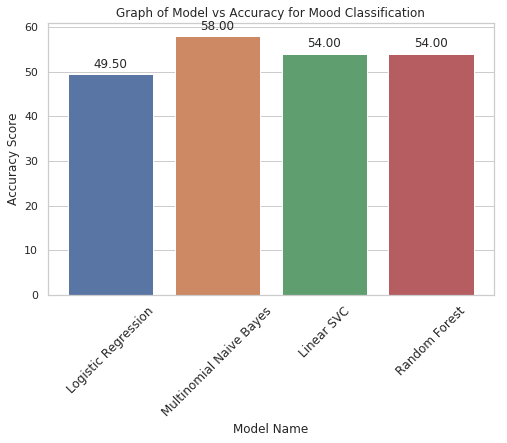

In [0]:
plt.figure(figsize=(8,5))
sns.set(style ="whitegrid")
ax=sns.barplot(x=mood_model_name, y=mood_model_accuracies)
ax.set(xlabel="Model Name", ylabel='Accuracy Score')
sns.set_style("ticks", {"xtick.major.size":10,"ytick.major.size":10})
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xticks(fontsize=12, rotation=45)
plt.title('Graph of Model vs Accuracy for Mood Classification')
plt.plot()

[]

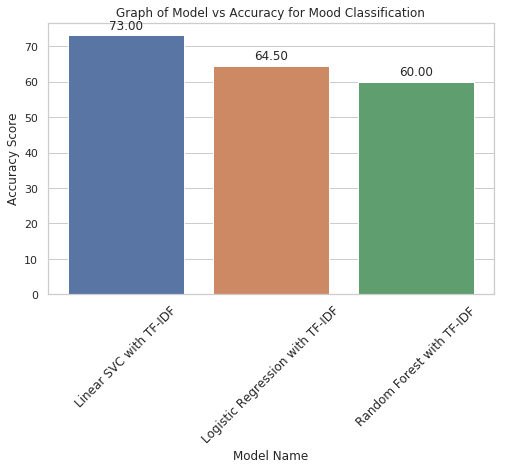

In [0]:
plt.figure(figsize=(8,5))
sns.set(style ="whitegrid")
ax=sns.barplot(x=mood_tfidf_model_name, y=mood_tfidf_model_accu)
ax.set(xlabel="Model Name", ylabel='Accuracy Score')
sns.set_style("ticks", {"xtick.major.size":10,"ytick.major.size":10})
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xticks(fontsize=12, rotation=45)
plt.title('Graph of Model vs Accuracy for Mood Classification')
plt.plot()

##Implementing Deep Learning Techniques

In [0]:
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import InputLayer
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.models import Sequential
from keras.layers import LSTM, Activation
from keras.layers import Input

Using TensorFlow backend.


In [0]:
# Multi-layer-Perceptron Implementation:

X_train = train_lyrics['Cleaned_Lyric']
X_valid = valid_lyrics['Cleaned_Lyric']
Y_train = train_lyrics["mood"]
Y_valid = valid_lyrics["mood"]

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

train_texts = list(X_train.values.astype('U'))
valid_texts = list(X_valid.values.astype('U'))
train_label = np.array(Y_train)
valid_label = np.array(Y_valid)


topK = 20000
def vectorization_for_MLP(train_texts, train_labels, val_texts, val_labels):
    
	# Keyword arguments for the TF-IDF vectorizer.
    kwargs = {
            'ngram_range': (1,2),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',
            'stop_words': 'english',
			      'lowercase': True,
            'min_df': 2,
			      }
    vectorizer = TfidfVectorizer(**kwargs)

    # Vectorize Training and Validation texts.
    x_train = vectorizer.fit_transform(train_texts)
    x_val = vectorizer.transform(val_texts)

    #Vectorize both train_labels and val_labels
    y_train = vectorizer.fit_transform(train_labels)
    y_val = vectorizer.transform(val_labels)
    
    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(topK, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val, y_train, y_val


X__train, X__valid, y__train, y__valid = vectorization_for_MLP(train_texts, train_label, valid_texts, valid_label)

In [0]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dropout
from keras.layers import Dense
from keras.models import Sequential, Model
from keras.layers import InputLayer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


def train_MLP_model(data):
  layers = 2
  units = 128
  learning_rate=1e-3
  epochs=10
  batch_size=100
  dropout_rate=0.2
  num_classes=2
  loss = 'binary_crossentropy'
  op_activation = 'sigmoid'
        
  mlp_model = Sequential()
  mlp_model.add(InputLayer(X__train.shape[1:]))
  mlp_model.add(Dropout(rate=dropout_rate))

  for i in range(layers-1):
    mlp_model.add(Dense(units=units, activation='relu'))
    mlp_model.add(Dropout(rate=dropout_rate))

  mlp_model.add(Dense(units=num_classes, activation=op_activation))
  mlp_model.summary()

  optimizer = Adam(lr=learning_rate)
  mlp_model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

  # Train and validate model.
  fitted_model = mlp_model.fit(
          X__train, y__train,
          epochs=epochs,
          validation_data=(X__valid, y__valid),
          verbose=2,
          batch_size=batch_size)
  score_mlp = mlp_model.evaluate(X__valid, y__valid, verbose=0)
  print("Test Accuracy of MLP" , (score_mlp[1]*100),"%")


train_MLP_model(X__train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_32 (Dropout)         (None, 9983)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               1277952   
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 258       
Total params: 1,278,210
Trainable params: 1,278,210
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 200 samples
Epoch 1/10
 - 5s - loss: 0.6901 - acc: 0.5675 - val_loss: 0.6902 - val_acc: 0.4775
Epoch 2/10
 - 1s - loss: 0.6660 - acc: 0.6055 - val_loss: 0.6834 - val_acc: 0.4850
Epoch 3/10
 - 1s - loss: 0.6296 - acc: 0.6695 - val

In [0]:
from sklearn.model_selection import train_test_split
lyricals_train = train_lyrics['Cleaned_Lyric'].values
moods_train = train_lyrics['mood'].values
lyricals_test = valid_lyrics['Cleaned_Lyric'].values
moods_test = valid_lyrics['mood'].values
#lyricals_train, lyricals_test, train_lab, test_lab = train_test_split(lyricals, moods, test_size=0.25, random_state=1000)

In [0]:
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

def max_length(lines):
	return max([len(s) for s in lines])

def encode_text(tokenizer, lines, length):
	encoded = tokenizer.texts_to_sequences(lines)
	padded = pad_sequences(encoded, maxlen=length, padding = 'post')
	return padded

In [0]:
tokenizer = create_tokenizer(lyricals_train)
length = max_length(lyricals_train)
vocab_size = len(tokenizer.word_index) + 1
train = encode_text(tokenizer, lyricals_train, length)
print(train.shape)
test = encode_text(tokenizer, lyricals_test, length)

(1000, 3770)


In [0]:
train_labels = []
for y in moods_train:
  if y=='happy':
    train_labels.append(0)
  else:
    train_labels.append(1)

test_labels = []
for y in moods_test:
  if y=='happy':
    test_labels.append(0)
  else:
    test_labels.append(1)

In [0]:
#CNN Implementation
model_cnn = Sequential()
model_cnn.add(InputLayer((length,)))
model_cnn.add(Activation('relu'))
model_cnn.add(Embedding(vocab_size, 100))
model_cnn.add(Conv1D(filters=100, kernel_size=2, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(MaxPooling1D(pool_size=3))
model_cnn.add(Flatten())
model_cnn.add(Dense(10, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()
model_cnn.fit(train, train_labels, epochs=5, batch_size=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_8 (Activation)    (None, 3770)              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 3770, 100)         1018900   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 3769, 100)         20100     
_________________________________________________________________
dropout_40 (Dropout)         (None, 3769, 100)         0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 1256, 100)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 125600)            0         
_________________________________________________________________
dense_47 (Dense)             (None, 10)                1256010   
__________

In [0]:
score_cnn = model_cnn.evaluate(test, test_labels, verbose=0)
print("Test Accuracy of CNN:",(score_cnn[1]*100),"%")


Test Accuracy of CNN: 69.0 %


In [0]:
from keras.layers import GlobalMaxPooling1D
def glove_feature_matrix(file, word_index, embedding_dim):
    vsize = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(file) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

feature_set_matrix = glove_feature_matrix('glove.6B.100d.txt',tokenizer.word_index, 100)


model_Glove = Sequential()
model_Glove.add(Embedding(vocab_size, 100, weights=[feature_set_matrix], input_length=length))
model_Glove.add(Conv1D(100, 3, activation='relu'))
model_Glove.add(GlobalMaxPooling1D())
model_Glove.add(Dense(10, activation='relu'))
model_Glove.add(Dense(1, activation='sigmoid'))
model_Glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_Glove.summary()

model_Glove.fit(train, train_labels,epochs=5,batch_size=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3770, 100)         1018900   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3768, 100)         30100     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,050,021
Trainable params: 1,050,021
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 

In [0]:
score_glove_cnn = model_Glove.evaluate(test, test_labels, verbose=0)
print("Test Accuracy for GloVe feature extracted+CNN", score_glove_cnn[1]*100, "%")


Test Accuracy for GloVe feature extracted+CNN 68.0 %


##Confusion Matrix for top 2 best models

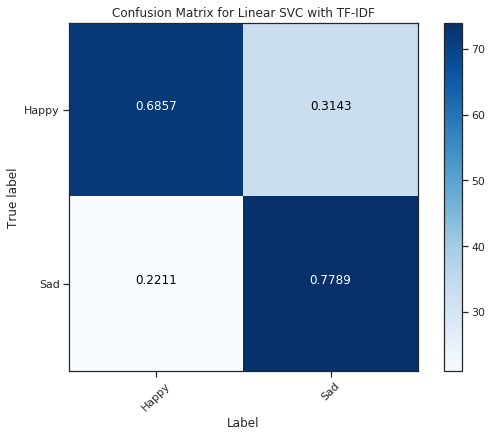

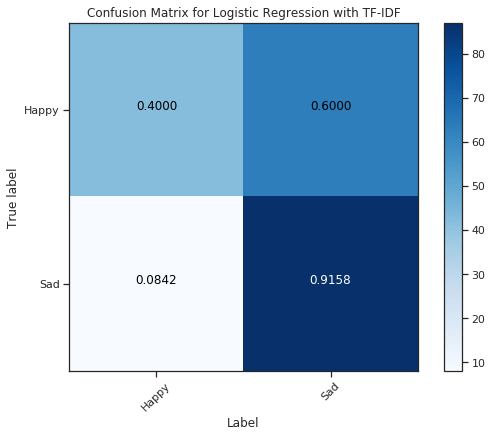

In [0]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

mood_labels=['Happy', 'Sad']

def plot_confusion_matrix(cm,
                          target_names,
                          modelname,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Label')
    if modelname=='Linear SVC':
      plt.title('Confusion Matrix for Linear SVC with TF-IDF')
    elif modelname=='Logistic Regression':
      plt.title('Confusion Matrix for Logistic Regression with TF-IDF')
    plt.show()

#Confusion Matrix for Linear SVC with TF-IDF
cm_lsvc = confusion_matrix(y_test, y_test_pred_lsvc)
plot_confusion_matrix(cm_lsvc, mood_labels,'Linear SVC')

#Confusion Matrix for Logistic Regression with TF-IDF
cm_logreg = confusion_matrix(y_test, y_test_pred_logreg)
plot_confusion_matrix(cm_logreg, mood_labels, 'Logistic Regression')